# Forecasting - Facebook Prophet

- explicit look into the future
- how to judge if a forecast is good or not

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet
%matplotlib inline
# This shows an example of the "fivethirtyeight" styling, which tries to replicate the styles from FiveThirtyEight.com.
# 538, is a website that focuses on opinion poll analysis, politics, economics, and sports blogging.
plt.style.use('fivethirtyeight')

## Trivial Forecast (rolling mean)
- how to judge if the forecase is good -> reference model
- rolling command over 3 days as it a very stable forecast when data doesnt move so much

In [168]:
# Toy data
df = pd.DataFrame({'X' : np.arange(0,10)})
df['y'] = df.rolling(3).mean()
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


## Small data set

In [169]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep = ';')
df = df_all[['date', 'Germany']]
df = df.rename(columns = {'date' : 'ds', 'Germany' : 'y'})
df.head()

,ds,y
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


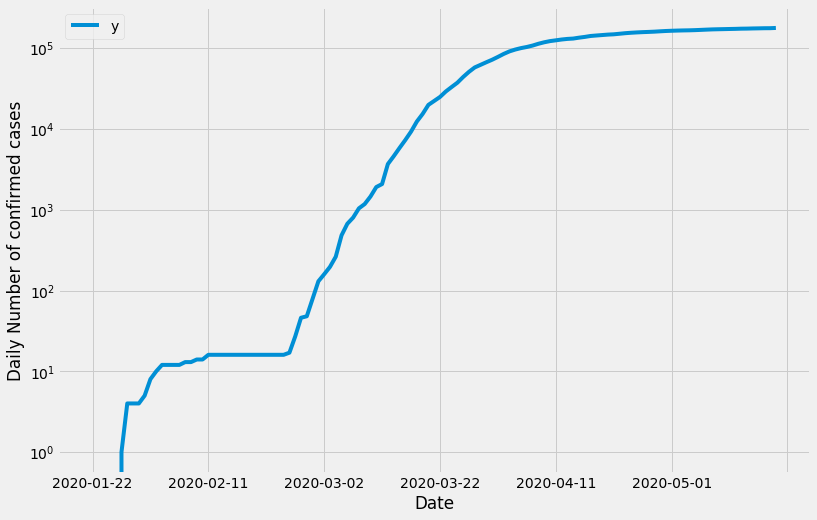

In [170]:
ax = df.set_index('ds').plot(figsize = (12,8), logy = True) 
ax.set_ylabel('Daily Number of confirmed cases')
ax.set_xlabel('Date')
plt.show()

In [171]:
# FB Prophet shows some good techiques to for cross-validation and trend detection
# Uncertainity depends on the trend in the history and assumes for the future
# We assume an uncertainity of 95%
#my_model = Prophet(interval_width = 0.95)
my_model = Prophet(growth = 'logistic') # https://peerj.com/preprints/3190.pdf -> pg.8

In [172]:
df['cap'] = 1000000. # assuming a capacity
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
future_dates = my_model.make_future_dataframe(periods = 7, freq = 'D') # D is day ; periods = predicts for 7 days
future_dates['cap'] = 1000000.
future_dates.tail()

,ds,cap
121,2020-05-22,1000000.0
122,2020-05-23,1000000.0
123,2020-05-24,1000000.0
124,2020-05-25,1000000.0
125,2020-05-26,1000000.0


In [174]:
# we forecast for the last 7 days
forecast = my_model.predict(future_dates)

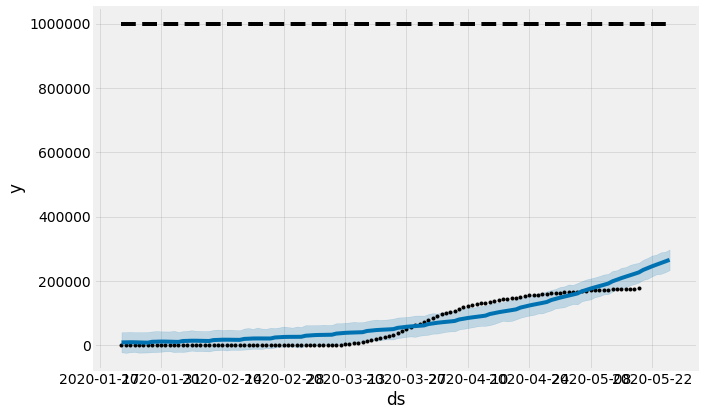

In [175]:
my_model.plot(forecast, uncertainty = True); # uncertainty is the blue shaded area

In [176]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)

fig.update_layout(
width = 1024,
height = 900,
xaxis_title = "Time",
yaxis_title = "Confirmed infected people(source john hopkins csse, log-scale)",
)
fig.update_yaxes(type = "log", range = [1.1, 5.5])
py.iplot(fig)

In [177]:
# Inner behavoir of FB prophet
forecast.sort_values(by = 'ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,8379.866493,1000000.0,-21483.043534,40773.224899,8379.866493,8379.866493,780.427429,780.427429,780.427429,780.427429,780.427429,780.427429,0.0,0.0,0.0,9160.293922
1,2020-01-23,8634.710388,1000000.0,-23214.981124,41011.572473,8634.710388,8634.710388,805.228781,805.228781,805.228781,805.228781,805.228781,805.228781,0.0,0.0,0.0,9439.939169
2,2020-01-24,8897.234918,1000000.0,-21370.488612,41636.411685,8897.234918,8897.234918,893.999470,893.999470,893.999470,893.999470,893.999470,893.999470,0.0,0.0,0.0,9791.234388
3,2020-01-25,9167.667275,1000000.0,-20518.238454,40825.135709,9167.667275,9167.667275,432.825823,432.825823,432.825823,432.825823,432.825823,432.825823,0.0,0.0,0.0,9600.493098
4,2020-01-26,9446.241107,1000000.0,-22737.667815,40788.152726,9446.241107,9446.241107,-248.937545,-248.937545,-248.937545,-248.937545,-248.937545,-248.937545,0.0,0.0,0.0,9197.303562


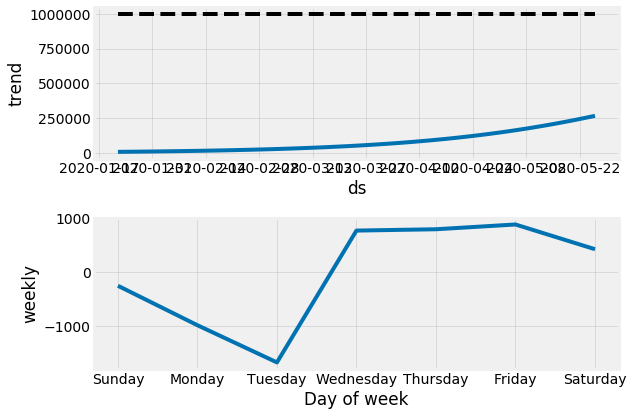

In [178]:
my_model.plot_components(forecast);

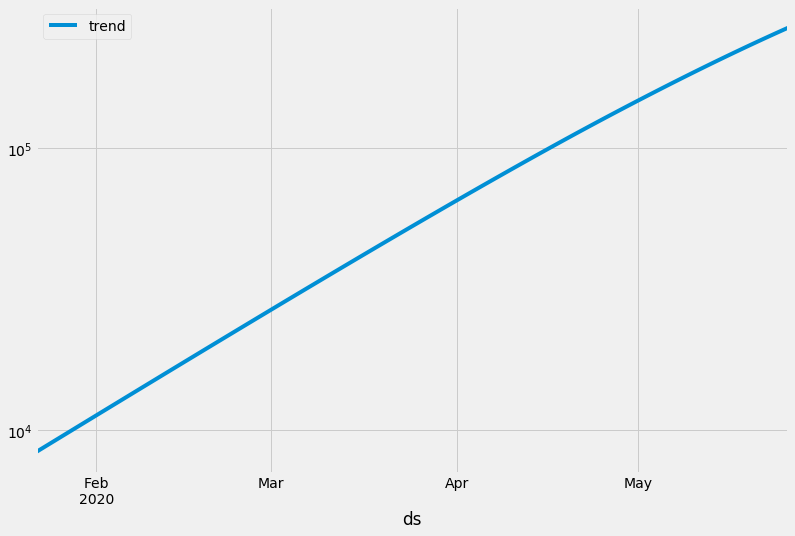

In [179]:
forecast[['ds', 'trend']].set_index('ds').plot(figsize = (12,8), logy = True)

In [180]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(
my_model,
initial = '30 days',
period = '1 days',
horizon = '7 days')

df_cv.head()

INFO:fbprophet:Making 82 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-05-12 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.083972,18.195804,26.002936,16,2020-02-21
1,2020-02-23,23.527319,19.476406,27.479632,16,2020-02-21
2,2020-02-24,25.008812,20.905480,28.874556,16,2020-02-21
3,2020-02-25,27.030574,23.188287,31.254911,17,2020-02-21
4,2020-02-26,26.884930,23.075774,31.005867,27,2020-02-21


In [181]:
df_cv.sort_values(by= ['cutoff', 'ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.083972,18.195804,26.002936,16,2020-02-21
1,2020-02-23,23.527319,19.476406,27.479632,16,2020-02-21
2,2020-02-24,25.008812,20.905480,28.874556,16,2020-02-21
3,2020-02-25,27.030574,23.188287,31.254911,17,2020-02-21
4,2020-02-26,26.884930,23.075774,31.005867,27,2020-02-21
5,2020-02-27,27.826000,23.628566,31.903848,46,2020-02-21
6,2020-02-28,29.218875,25.414095,33.069953,48,2020-02-21
7,2020-02-23,22.424136,18.697379,26.579647,16,2020-02-22
8,2020-02-24,23.807094,20.043200,27.881284,16,2020-02-22
9,2020-02-25,25.722912,21.717335,29.865954,17,2020-02-22


In [182]:
df[['ds', 'y']][30:]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,17
...,...,...
114,2020-05-15,175233
115,2020-05-16,175752
116,2020-05-17,176369
117,2020-05-18,176551


In [183]:
# We check the mean-squared error and other metrics
# Smaller the horizon, better the prediction should be
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,8.230870e+08,28689.492492,20524.197793,0.262930,0.254401,0.024390
1,2 days,1.133086e+09,33661.342782,24934.813057,0.322004,0.313922,0.012195
2,3 days,1.536872e+09,39202.964113,29900.600484,0.375503,0.358507,0.024390
3,4 days,2.059117e+09,45377.499741,35474.624834,0.434313,0.413900,0.012195
4,5 days,2.732140e+09,52269.874597,41739.303161,0.493211,0.468403,0.012195
5,6 days,3.599127e+09,59992.725316,48781.507425,0.567445,0.543107,0.000000
6,7 days,4.713792e+09,68657.059785,56677.511625,0.642852,0.638038,0.000000


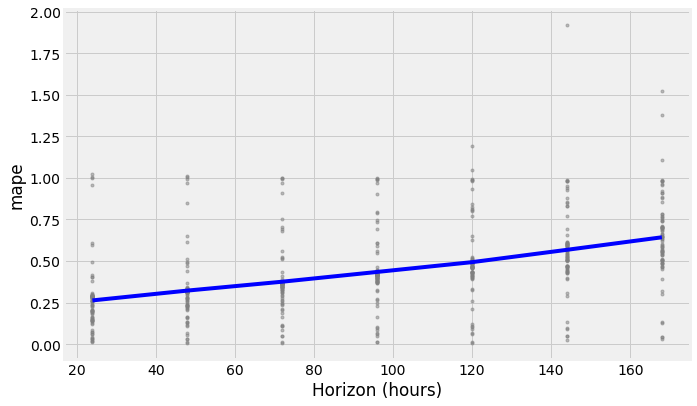

In [192]:
 from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = 'mape',)
# Error reduced from .75 to 0.25

## Diagonal Plot

- Every forecase model has to be checked by a diagonal model
- Errors in underestimating or overestimating


In [193]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
0,2020-02-22,22.083972,18.195804,26.002936,16,2020-02-21,1 days
1,2020-02-23,23.527319,19.476406,27.479632,16,2020-02-21,2 days
2,2020-02-24,25.008812,20.905480,28.874556,16,2020-02-21,3 days
3,2020-02-25,27.030574,23.188287,31.254911,17,2020-02-21,4 days
4,2020-02-26,26.884930,23.075774,31.005867,27,2020-02-21,5 days


In [194]:
horizon = '7 days'
# Creating a new column
df_cv['horizon'] = df_cv.ds - df_cv.cutoff

# Values at df_cv['horizon'] which are equal to 7 days and take the corresponding 'ds','yhat','y' values
date_vec = df_cv[df_cv['horizon'] == horizon]['ds']
# Prediction
y_hat = df_cv[df_cv['horizon'] == horizon]['yhat']
# Ground truth
y = df_cv[df_cv['horizon'] == horizon]['y']

In [195]:
df_cv_7 = df_cv[df_cv['horizon'] == horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
545,2020-05-15,263434.937982,237285.236514,287018.533571,175233,2020-05-08,7 days
552,2020-05-16,258148.692342,231526.314594,281895.421458,175752,2020-05-09,7 days
559,2020-05-17,258721.837966,232186.174745,286110.251943,176369,2020-05-10,7 days
566,2020-05-18,258866.715789,230246.816568,286563.926802,176551,2020-05-11,7 days
573,2020-05-19,257611.744671,230504.474062,285647.743372,177778,2020-05-12,7 days


In [196]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

In [197]:
y.head()

6      48
13     79
20    130
27    159
34    196
Name: y, dtype: int64

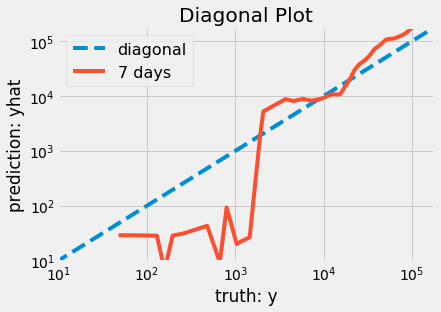

In [198]:
fig, ax = plt.subplots(1,1)

# 'y' infection rate of Germany
ax.plot(np.arange(max(y)), np.arange(max(y)), '--', label = 'diagonal')
ax.plot(y, y_hat, '-', label = horizon)

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediction: yhat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc = 'best',
         prop = {'size':16});

In [199]:
# Truth was way larger than the prediciton   
# FB Forecating model works based on the paper -> https://peerj.com/preprints/3190.pdf
# The red line is now similar to the ground truth
# Training for 1st 40 days
# The slope of the line can be bettered by SIR modelling